Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

First few rows:
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

Missing Values:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Classification Repo

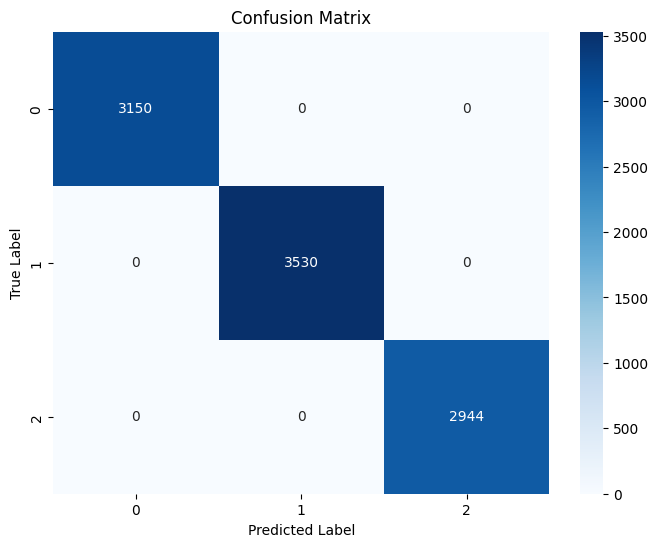

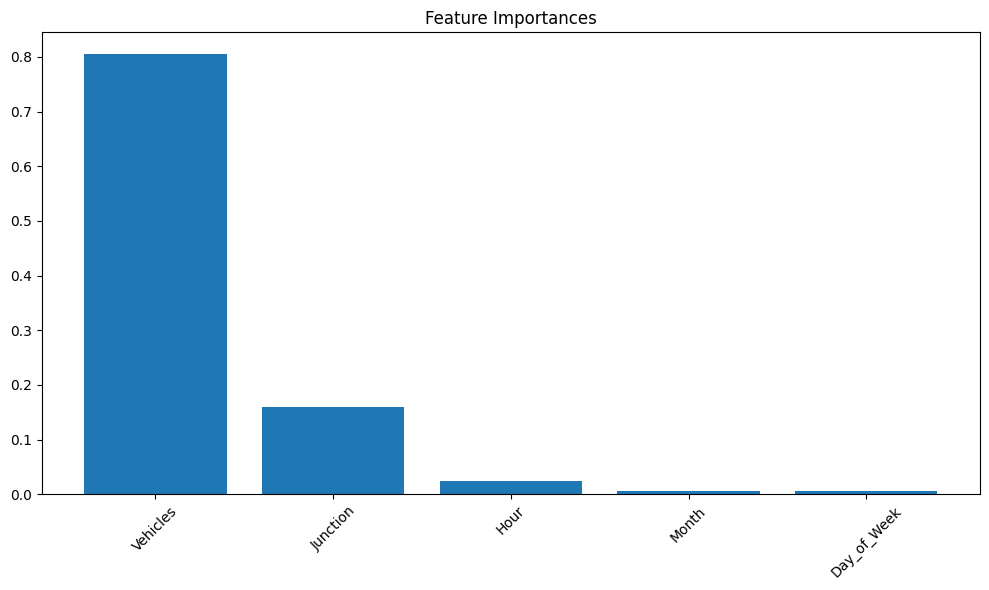

In [7]:
# Classifying Traffic Flow Patterns in Smart Cities
from google.colab import drive
drive.mount('/content/drive')

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Exploration
def load_and_explore_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Display basic information about the dataset
    print("Dataset Information:")
    print(df.info())

    # Display first few rows
    print("\nFirst few rows:")
    print(df.head())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df

# 2. Data Preprocessing
def preprocess_data(df):
    # Convert DateTime to datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Extract time-based features
    df['Hour'] = df['DateTime'].dt.hour
    df['Day_of_Week'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month

    # Encode categorical variables
    le_junction = LabelEncoder()
    df['Junction_Encoded'] = le_junction.fit_transform(df['Junction'])

    # Create traffic flow labels based on vehicle count
    def categorize_traffic_flow(vehicles):
        if vehicles <= df['Vehicles'].quantile(0.33):
            return 'Low'
        elif vehicles <= df['Vehicles'].quantile(0.66):
            return 'Medium'
        else:
            return 'High'

    df['Traffic_Flow_Label'] = df['Vehicles'].apply(categorize_traffic_flow)

    return df, le_junction

# 3. Feature Selection and Preparation
def prepare_features(df):
    # Select features for classification
    features = ['Hour', 'Day_of_Week', 'Month', 'Junction_Encoded', 'Vehicles']
    X = df[features]
    y = df['Traffic_Flow_Label']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# 4. Model Training and Evaluation
def train_random_forest_classifier(X_train, X_test, y_train, y_test):
    # Initialize and train Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return rf_classifier

# 5. Feature Importance Visualization
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

# Main Execution
def main():
    # Load the dataset from Google Drive
    file_path = '/content/drive/MyDrive/FDP/Assignments/Task 2/traffic.csv'  # Adjusted path for Google Drive

    # Load and explore data
    df = load_and_explore_data(file_path)

    # Preprocess data
    df, le_junction = preprocess_data(df)

    # Prepare features
    X_train, X_test, y_train, y_test, scaler = prepare_features(df)

    # Train and evaluate the model
    feature_names = ['Hour', 'Day_of_Week', 'Month', 'Junction', 'Vehicles']
    rf_model = train_random_forest_classifier(X_train, X_test, y_train, y_test)

    # Plot feature importance
    plot_feature_importance(rf_model, feature_names)

# Run the main function
if __name__ == '__main__':
    main()
